The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release --no-deps --force-reinstall
!pip install numpy>=1.20

  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /tmp/pip-req-build-9_to5k5h
  Running command git clone --filter=blob:none --quiet https://github.com/d2l-ai/d2l-zh /tmp/pip-req-build-9_to5k5h
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  Branch 'release' set up to track remote branch 'release' from 'origin'.
  Resolved https://github.com/d2l-ai/d2l-zh to commit 843d3d41dca48d8df65f4b324dd171d8bfe9c067
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Created wheel for d2l: filename=d2l-2.0.0-py3-none-any.whl size=110800 sha256=d4048966c6a44f9e9922e5622711be12b40c8b37b11c72641cc1ec3720f96c31
  Stored in directory: /tmp/pip-ephem-wheel-cache-3b0c__33/wheels/3e/87/36/53b013ece7da539a59fcc56da2d329d7afb08eef9a9a5ae1d1
Successfully built d2l
  Attempting uninstall: d2l
    Found existing installation: d2l 2.0.0
    Uninstalling d2l-2.0.0:
      Successfully uni

# 注意力汇聚：Nadaraya-Watson 核回归
:label:`sec_nadaraya-watson`

上节介绍了框架下的注意力机制的主要成分 :numref:`fig_qkv`：
查询（自主提示）和键（非自主提示）之间的交互形成了注意力汇聚；
注意力汇聚有选择地聚合了值（感官输入）以生成最终的输出。
本节将介绍注意力汇聚的更多细节，
以便从宏观上了解注意力机制在实践中的运作方式。
具体来说，1964年提出的Nadaraya-Watson核回归模型
是一个简单但完整的例子，可以用于演示具有注意力机制的机器学习。


In [2]:
import torch
from torch import nn
from d2l import torch as d2l

## [**生成数据集**]

简单起见，考虑下面这个回归问题：
给定的成对的“输入－输出”数据集
$\{(x_1, y_1), \ldots, (x_n, y_n)\}$，
如何学习$f$来预测任意新输入$x$的输出$\hat{y} = f(x)$？

根据下面的非线性函数生成一个人工数据集，
其中加入的噪声项为$\epsilon$：

$$y_i = 2\sin(x_i) + x_i^{0.8} + \epsilon,$$

其中$\epsilon$服从均值为$0$和标准差为$0.5$的正态分布。
在这里生成了$50$个训练样本和$50$个测试样本。
为了更好地可视化之后的注意力模式，需要将训练样本进行排序。


In [3]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

In [4]:
def f(x):
  return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

下面的函数将绘制所有的训练样本（样本由圆圈表示），
不带噪声项的真实数据生成函数$f$（标记为“Truth”），
以及学习得到的预测函数（标记为“Pred”）。


In [5]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

## 平均汇聚

先使用最简单的估计器来解决回归问题。
基于平均汇聚来计算所有训练样本输出值的平均值：

$$f(x) = \frac{1}{n}\sum_{i=1}^n y_i,$$
:eqlabel:`eq_avg-pooling`

如下图所示，这个估计器确实不够聪明。
真实函数$f$（“Truth”）和预测函数（“Pred”）相差很大。


y_train.mean():  tensor(2.1639)
n_test:  50


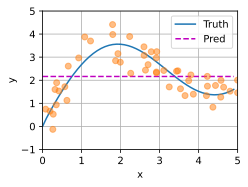

In [6]:
print("y_train.mean(): ",y_train.mean())
print("n_test: ", n_test)
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

## [**非参数注意力汇聚**]

显然，平均汇聚忽略了输入$x_i$。
于是Nadaraya :cite:`Nadaraya.1964`和
Watson :cite:`Watson.1964`提出了一个更好的想法，
根据输入的位置对输出$y_i$进行加权：

$$f(x) = \sum_{i=1}^n \frac{K(x - x_i)}{\sum_{j=1}^n K(x - x_j)} y_i,$$
:eqlabel:`eq_nadaraya-watson`

其中$K$是*核*（kernel）。
公式 :eqref:`eq_nadaraya-watson`所描述的估计器被称为
*Nadaraya-Watson核回归*（Nadaraya-Watson kernel regression）。
这里不会深入讨论核函数的细节，
但受此启发，
我们可以从 :numref:`fig_qkv`中的注意力机制框架的角度
重写 :eqref:`eq_nadaraya-watson`，
成为一个更加通用的*注意力汇聚*（attention pooling）公式：

$$f(x) = \sum_{i=1}^n \alpha(x, x_i) y_i,$$
:eqlabel:`eq_attn-pooling`

其中$x$是查询，$(x_i, y_i)$是键值对。
比较 :eqref:`eq_attn-pooling`和 :eqref:`eq_avg-pooling`，
注意力汇聚是$y_i$的加权平均。
将查询$x$和键$x_i$之间的关系建模为
*注意力权重*（attention weight）$\alpha(x, x_i)$，
如 :eqref:`eq_attn-pooling`所示，
这个权重将被分配给每一个对应值$y_i$。
对于任何查询，模型在所有键值对注意力权重都是一个有效的概率分布：
它们是非负的，并且总和为1。

为了更好地理解注意力汇聚，
下面考虑一个*高斯核*（Gaussian kernel），其定义为：

$$K(u) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{u^2}{2}).$$

将高斯核代入 :eqref:`eq_attn-pooling`和
 :eqref:`eq_nadaraya-watson`可以得到：

$$\begin{aligned} f(x) &=\sum_{i=1}^n \alpha(x, x_i) y_i\\ &= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}(x - x_j)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i. \end{aligned}$$
:eqlabel:`eq_nadaraya-watson-gaussian`

在 :eqref:`eq_nadaraya-watson-gaussian`中，
如果一个键$x_i$越是接近给定的查询$x$，
那么分配给这个键对应值$y_i$的注意力权重就会越大，
也就“获得了更多的注意力”。

值得注意的是，Nadaraya-Watson核回归是一个非参数模型。
因此， :eqref:`eq_nadaraya-watson-gaussian`是
*非参数的注意力汇聚*（nonparametric attention pooling）模型。
接下来，我们将基于这个非参数的注意力汇聚模型来绘制预测结果。
从绘制的结果会发现新的模型预测线是平滑的，并且比平均汇聚的预测更接近真实。


x_test.shape:  torch.Size([50])
x_test:  tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000,
        1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000,
        2.7000, 2.8000, 2.9000, 3.0000, 3.1000, 3.2000, 3.3000, 3.4000, 3.5000,
        3.6000, 3.7000, 3.8000, 3.9000, 4.0000, 4.1000, 4.2000, 4.3000, 4.4000,
        4.5000, 4.6000, 4.7000, 4.8000, 4.9000])
n_train:  50
X_repeat.shape:  torch.Size([50, 50])
attention_weights:  tensor([[7.6348e-02, 7.5182e-02, 7.3982e-02,  ..., 7.3591e-07, 2.8877e-07,
         2.8624e-07],
        [7.2226e-02, 7.1935e-02, 7.1289e-02,  ..., 1.1170e-06, 4.4676e-07,
         4.4291e-07],
        [6.8082e-02, 6.8582e-02, 6.8448e-02,  ..., 1.6894e-06, 6.8872e-07,
         6.8291e-07],
        ...,
        [1.3750e-06, 2.3088e-06, 3.1675e-06,  ..., 5.9316e-02, 5.7070e-02,
         5.7040e-02],
        [9.1664e-07, 1.5568e-06, 2.150

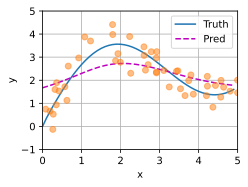

In [7]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
print("x_test.shape: ",x_test.shape)
print("x_test: ",x_test)
print("n_train: ",n_train)#将50个数每一行复制了50个
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
print("X_repeat.shape: ",X_repeat.shape)
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
#X_repeat - x_train是50*50 - 50*1  每个数都-一个数 dim=1是消掉
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)#每一个测试样本-所有的训练样本 计算每一个测试样本和训练样本的相似度 [50,50] 然后dim=1是计算其概率 得到的还是[50,50]

print("attention_weights: ",attention_weights)
print("attention_weights.shape: ",attention_weights.shape)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
print("y_train.shape: ",y_train.shape)
y_hat = torch.matmul(attention_weights, y_train)#得到就是50个样本 这50个样本是加权平均得到
plot_kernel_reg(y_hat) #因为有负号 所以离得越近 权重越大。

In [8]:
# 假设数据
y_train = torch.tensor([10.0, 20.0, 30.0])  # 3个训练样本的真实值
attention_weights = torch.tensor([
    [0.2, 0.5, 0.3],  # 测试样本0的注意力权重：与训练样本0相似度0.2，样本1相似度0.5，样本2相似度0.3
    [0.1, 0.1, 0.8]   # 测试样本1的注意力权重：与训练样本0相似度0.1，样本1相似度0.1，样本2相似度0.8
])

# 计算预测
y_hat = torch.matmul(attention_weights, y_train)
# y_hat[0] = 0.2 * 10 + 0.5 * 20 + 0.3 * 30 = 2 + 10 + 9 = 21.0
# y_hat[1] = 0.1 * 10 + 0.1 * 20 + 0.8 * 30 = 1 + 2 + 24 = 27.0

现在来观察注意力的权重。
这里测试数据的输入相当于查询，而训练数据的输入相当于键。
因为两个输入都是经过排序的，因此由观察可知“查询-键”对越接近，
注意力汇聚的[**注意力权重**]就越高。


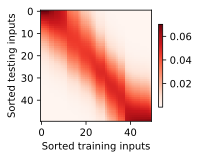

In [8]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0), #最终形状: [1, 1, 50, 50] (批次大小=1, 通道数=1, 高度=50, 宽度=50)
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

## [**带参数注意力汇聚**]

非参数的Nadaraya-Watson核回归具有*一致性*（consistency）的优点：
如果有足够的数据，此模型会收敛到最优结果。
尽管如此，我们还是可以轻松地将可学习的参数集成到注意力汇聚中。

例如，与 :eqref:`eq_nadaraya-watson-gaussian`略有不同，
在下面的查询$x$和键$x_i$之间的距离乘以可学习参数$w$：

$$\begin{aligned}f(x) &= \sum_{i=1}^n \alpha(x, x_i) y_i \\&= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}((x - x_i)w)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}((x - x_j)w)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}((x - x_i)w)^2\right) y_i.\end{aligned}$$
:eqlabel:`eq_nadaraya-watson-gaussian-para`

本节的余下部分将通过训练这个模型
 :eqref:`eq_nadaraya-watson-gaussian-para`来学习注意力汇聚的参数。

### 批量矩阵乘法

:label:`subsec_batch_dot`

为了更有效地计算小批量数据的注意力，
我们可以利用深度学习开发框架中提供的批量矩阵乘法。

假设第一个小批量数据包含$n$个矩阵$\mathbf{X}_1,\ldots, \mathbf{X}_n$，
形状为$a\times b$，
第二个小批量包含$n$个矩阵$\mathbf{Y}_1, \ldots, \mathbf{Y}_n$，
形状为$b\times c$。
它们的批量矩阵乘法得到$n$个矩阵
$\mathbf{X}_1\mathbf{Y}_1, \ldots, \mathbf{X}_n\mathbf{Y}_n$，
形状为$a\times c$。
因此，[**假定两个张量的形状分别是$(n,a,b)$和$(n,b,c)$，
它们的批量矩阵乘法输出的形状为$(n,a,c)$**]。


核心区别：权重 vs. 预测值
关键要区分两个概念：

​注意力权重（α）​​：表示相似度，其和总是等于1​

​预测值（f(x)）​​：是真实值 y_i的加权平均，其值取决于 y_i的大小

In [9]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

在注意力机制的背景中，我们可以[**使用小批量矩阵乘法来计算小批量数据中的加权平均值**]。


In [16]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
print("weights.unsqueeze(1): ", weights.unsqueeze(1).shape)
print("values.unsqueeze(-1): ", values.unsqueeze(-1).shape)

torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

weights.unsqueeze(1):  torch.Size([2, 1, 10])
values.unsqueeze(-1):  torch.Size([2, 10, 1])


tensor([[[ 4.5000]],

        [[14.5000]]])

### 定义模型

基于 :eqref:`eq_nadaraya-watson-gaussian-para`中的
[**带参数的注意力汇聚**]，使用小批量矩阵乘法，
定义Nadaraya-Watson核回归的带参数版本为：


In [10]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        #那这里的x_train的shape扩展到和key的shape一样 但是key已经是少了一个数了。
        print("queries.shape: ",queries.shape)
        print("keys.shape: ",keys.shape)
        print("values.shape: ",values.shape)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        @
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

您的理解完全正确！在留一法交叉验证（Leave-One-Out Cross-Validation）的上下文中  当 n_train = 3时，keys和 values的形状确实是 (3, 2)，因为每个样本都被排除一次。 queries被扩展到 (3, 2)是为了与 keys的维度匹配，从而计算注意力权重。
现在，让我们一步步分析 torch.bmm操作和最终输出的形状：  
维度变化详细说明  
​注意力权重 (self.attention_weights) 的形状​：  
在计算 softmax 之后，self.attention_weights的形状是 (3, 2)。这表示有 3 个查询点（每个对应一个留一案例），每个查询点有 2 个权重值（对应两个训练样本）。
​unsqueeze 操作​：  
self.attention_weights.unsqueeze(1)：在维度 1 上添加一个维度，形状从 (3, 2)变为 (3, 1, 2)。  
values.unsqueeze(-1)：在最后一个维度上添加一个维度，形状从 (3, 2)变为 (3, 2, 1)。  
​批量矩阵乘法 (torch.bmm)​​：  
torch.bmm执行批量矩阵乘法，要求输入形状为 (batch_size, n, m)和 (batch_size, m, p)。  
这里，输入是 (3, 1, 2)和 (3, 2, 1)，因此输出形状为 (3, 1, 1)。
计算过程：对于每个批次（即每个查询点），进行矩阵乘法 (1, 2) * (2, 1) = (1, 1)，结果是一个标量。  
例如，对于第一个查询点：注意力权重 [w1, w2]与值 [v1, v2]相乘，得到 w1*v1 + w2*v2。  
​reshape(-1) 操作​：  
torch.bmm输出形状为 (3, 1, 1)，使用 reshape(-1)将其展平，得到形状 (3,)。
这表示最终输出是一个包含 3 个元素的一维张量，每个元素是对应查询点的预测值。  
最终输出形状  
​最终输出的形状是 (3,)，即一个长度为 3 的向量。每个元素对应一个留一案例的预测值：  
第 0 个元素：使用样本 1 和 2 预测样本 0 的值。  
第 1 个元素：使用样本 0 和 2 预测样本 1 的值。  
第 2 个元素：使用样本 0 和 1 预测样本 2 的值。  
为什么这样设计？  
这种设计允许我们一次性计算所有留一案例的预测值，而不是通过循环逐个计算，从而提高了计算效率。最终输出的形状 (3,)与原始训练样本的数量一致，便于后续计算评估指标（如均方误差）。  

### 训练

接下来，[**将训练数据集变换为键和值**]用于训练注意力模型。
在带参数的注意力汇聚模型中，
任何一个训练样本的输入都会和除自己以外的所有训练样本的“键－值”对进行计算，
从而得到其对应的预测输出。


In [15]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1) torch.eye(n_train): 生成n_train*n_train的矩阵。1 - torch.eye(n_train) 岂不是其他为-1 中间斜线为0？留一法 每一行 都是去除一个为测试集 其他两个是训练集
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1)) #keys = X_tile[mask].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1)) #values = Y_tile[mask].reshape((n_train, -1))

1 - torch.eye(n_train)将对角线变为0，其他变为1。例如：  
复制[[0, 1, 1],  
 [1, 0, 1],  
 [1, 1, 0]]  

[**训练带参数的注意力汇聚模型**]时，使用平方损失函数和随机梯度下降。


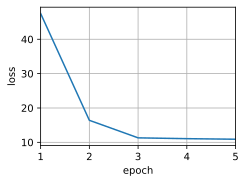

In [18]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

如下所示，训练完带参数的注意力汇聚模型后可以发现：
在尝试拟合带噪声的训练数据时，
[**预测结果绘制**]的线不如之前非参数模型的平滑。


queries.shape:  torch.Size([50])
keys.shape:  torch.Size([50, 50])
values.shape:  torch.Size([50, 50])


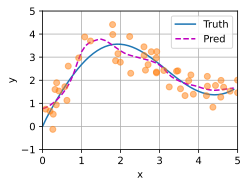

In [19]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train) 每一行包含着相同的训练输入（例如，相同的值）
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

为什么新的模型更不平滑了呢？
下面看一下输出结果的绘制图：
与非参数的注意力汇聚模型相比，
带参数的模型加入可学习的参数后，
[**曲线在注意力权重较大的区域变得更不平滑**]。


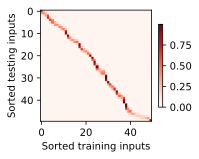

In [15]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

## 小结

* Nadaraya-Watson核回归是具有注意力机制的机器学习范例。
* Nadaraya-Watson核回归的注意力汇聚是对训练数据中输出的加权平均。从注意力的角度来看，分配给每个值的注意力权重取决于将值所对应的键和查询作为输入的函数。
* 注意力汇聚可以分为非参数型和带参数型。

## 练习

1. 增加训练数据的样本数量，能否得到更好的非参数的Nadaraya-Watson核回归模型？
1. 在带参数的注意力汇聚的实验中学习得到的参数$w$的价值是什么？为什么在可视化注意力权重时，它会使加权区域更加尖锐？
1. 如何将超参数添加到非参数的Nadaraya-Watson核回归中以实现更好地预测结果？
1. 为本节的核回归设计一个新的带参数的注意力汇聚模型。训练这个新模型并可视化其注意力权重。


[Discussions](https://discuss.d2l.ai/t/5760)


In [ ]:
import torch
import torch.nn as nn

class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # 将 queries 从 (batch_size,) 扩展为 (batch_size, m)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))

        # 计算注意力权重
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)

        # 计算加权平均值
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

# 创建模型
model = NWKernelRegression()

# 准备数据 - 注意这里的 batch_size = 2
# 键 (Keys): 形状 (2, 3) - 2个批次，每个批次3个键
keys = torch.tensor([
    [80.0, 100.0, 120.0],    # 数据集A的键
    [10.0, 20.0, 30.0]       # 数据集B的键
])

# 值 (Values): 形状 (2, 3) - 2个批次，每个批次3个值
values = torch.tensor([
    [400.0, 500.0, 600.0],   # 数据集A的值
    [60.0, 80.0, 90.0]       # 数据集B的值
])

# 查询 (Queries): 形状 (2,) - 2个查询点
queries = torch.tensor([90.0, 15.0])  # 查询: 90平方米的房价和15小时学习后的成绩

# 进行预测
predictions = model(queries, keys, values)
print(f"预测结果: {predictions}")